# Correlation Analysis: News Sentiment and Stock Movement (Task 3)

## Notebook Overview

This notebook focuses on **Task 3: Correlation between news and stock movement**. It covers the integration of financial news sentiment with stock price data, performs sentiment analysis on headlines, and calculates the correlation between news sentiment and daily stock returns.

### Objectives:
* Align news and stock data by date.
* Conduct sentiment analysis on news headlines.
* Calculate daily stock returns.
* Determine the correlation between news sentiment and stock movements.

## 1. Setup and Data Loading

This section prepares the environment and loads the necessary datasets for correlation analysis.

### 1.1 Import Libraries

We'll import `pandas` for data manipulation, `yfinance` to potentially re-load stock data, and `nltk`/`textblob` for sentiment analysis.

In [2]:
# Code Cell: Import Libraries
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download NLTK data (run only if not already downloaded)
# try:
#     nltk.data.find('sentiment/vader_lexicon')
# except nltk.downloader.DownloadError:
#     nltk.download('vader_lexicon')

# Configure plot styles
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6) # Default figure size

print("Libraries imported and NLTK data checked.")

Libraries imported and NLTK data checked.


### 1.2 Load Stock and News Data

We load the processed stock data (which ideally includes 'Daily_Return' from Task 2) and the raw financial news dataset. We'll re-load stock data directly here for notebook self-containment, ensuring columns are flattened.

In [11]:
# Code Cell: Load News Data
news_data_path = '../data/raw_analyst_ratings.csv' # Adjust path as needed based on your file location

try:
    news_df = pd.read_csv(news_data_path)
    print(f"\nLoaded news data from {news_data_path}")
except FileNotFoundError:
    print(f"Error: News data file not found at {news_data_path}. Please create or adjust path.")
    # Create an empty DataFrame with expected columns for graceful handling downstream
    news_df = pd.DataFrame(columns=['headline', 'date', 'stock'])
except Exception as e:
    print(f"An unexpected error occurred while loading news data: {e}")
    news_df = pd.DataFrame(columns=['headline', 'date', 'stock'])


# Convert 'date' column to datetime and normalize
if 'date' in news_df.columns:
    print("\n--- Attempting Date Column Conversion ---")
    print(f"Original 'date' column dtype: {news_df['date'].dtype}")
    print(f"Sample raw date values: {news_df['date'].head(5).tolist()}") # Inspect this output carefully!

    # Convert to datetime, coercing errors to NaT (Not a Time)
    news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')

    # Drop rows where date could not be parsed
    initial_news_rows = news_df.shape[0]
    news_df.dropna(subset=['date'], inplace=True)
    rows_after_date_dropna = news_df.shape[0]
    if initial_news_rows != rows_after_date_dropna:
        print(f"Dropped {initial_news_rows - rows_after_date_dropna} rows from news data due to unparseable dates.")

    # Handle timezone as specified in the challenge: "UTC-4 timezone" 
    # If the date strings already have timezone info, tz_localize will warn or fail,
    # so we first check if timezone info is present.
    if news_df['date'].dt.tz is None:
        # If no timezone info, assume it's in America/New_York (UTC-4/EST/EDT) 
        news_df['date'] = news_df['date'].dt.tz_localize('America/New_York', ambiguous='infer', nonexistent='NaT')
        print("Date column localized to 'America/New_York' timezone.")
    else:
        print("Date column already contains timezone information.")

    # Convert all dates to UTC for consistency in analysis
    news_df['date'] = news_df['date'].dt.tz_convert('UTC')
    print("Date column converted to UTC.")


    # Create a 'date_only' column for merging, normalized to the start of the day in UTC
    news_df['date_only'] = news_df['date'].dt.normalize()
    print("News 'date' column processed and 'date_only' created.")
else:
    print("Warning: 'date' column not found in news_df. Cannot process dates.")

print("\nNews Data Head (after date processing):")
print(news_df[['headline', 'date', 'date_only']].head())


Loaded news data from ../data/raw_analyst_ratings.csv

--- Attempting Date Column Conversion ---
Original 'date' column dtype: object
Sample raw date values: ['2020-06-05 10:30:54-04:00', '2020-06-03 10:45:20-04:00', '2020-05-26 04:30:07-04:00', '2020-05-22 12:45:06-04:00', '2020-05-22 11:38:59-04:00']
Dropped 1351341 rows from news data due to unparseable dates.
Date column already contains timezone information.
Date column converted to UTC.
News 'date' column processed and 'date_only' created.

News Data Head (after date processing):
                                            headline  \
0            Stocks That Hit 52-Week Highs On Friday   
1         Stocks That Hit 52-Week Highs On Wednesday   
2                      71 Biggest Movers From Friday   
3       46 Stocks Moving In Friday's Mid-Day Session   
4  B of A Securities Maintains Neutral on Agilent...   

                       date                 date_only  
0 2020-06-05 14:30:54+00:00 2020-06-05 00:00:00+00:00  
1 2020-0

## 2. Sentiment Analysis

This section performs sentiment analysis on the news headlines to quantify their emotional tone. We use NLTK's VADER (Valence Aware Dictionary and sEntiment Reasoner) for its effectiveness with social media and news-like text.

In [12]:
import nltk

# Define a custom directory for NLTK data (optional, but can help if default paths have permission issues)
# If you choose a custom path, remember to add it to NLTK's data path later
# nltk.data.path.append('/path/to/your/nltk_data_directory')

print("Attempting to download 'vader_lexicon'...")
try:
    nltk.download('vader_lexicon')
    print("'vader_lexicon' downloaded successfully!")
except Exception as e:
    print(f"Error during NLTK download: {e}")
    print("Please ensure you have an active internet connection and sufficient disk space.")

print("\nAttempting to download 'punkt' (often needed for TextBlob, good to have):")
try:
    nltk.download('punkt')
    print("'punkt' downloaded successfully!")
except Exception as e:
    print(f"Error during NLTK download: {e}")
    print("Please ensure you have an active internet connection and sufficient disk space.")

# You can also list all downloaded packages to verify
# print("\nNLTK packages info:")
# nltk.download('all', download_dir='./nltk_data', quiet=True) # Downloads all to a local folder
# You might then need to add: nltk.data.path.append('./nltk_data')

Attempting to download 'vader_lexicon'...
'vader_lexicon' downloaded successfully!

Attempting to download 'punkt' (often needed for TextBlob, good to have):
'punkt' downloaded successfully!


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Abeni/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Abeni/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


VADER sentiment scores calculated for news headlines.

News data with sentiment_score (first 5 rows):
                                            headline  sentiment_score
0            Stocks That Hit 52-Week Highs On Friday            0.000
1         Stocks That Hit 52-Week Highs On Wednesday            0.000
2                      71 Biggest Movers From Friday            0.000
3       46 Stocks Moving In Friday's Mid-Day Session            0.000
4  B of A Securities Maintains Neutral on Agilent...            0.296

Sentiment Score Statistics:
count    55987.000000
mean         0.066572
std          0.313522
min         -0.938200
25%          0.000000
50%          0.000000
75%          0.202300
max          0.966600
Name: sentiment_score, dtype: float64


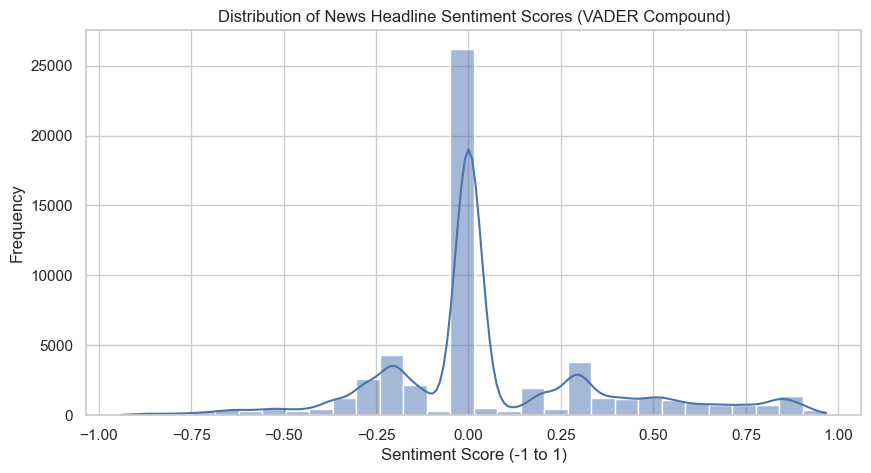

In [13]:
# Code Cell: Perform Sentiment Analysis 
if 'headline' in news_df.columns:
    analyzer = SentimentIntensityAnalyzer()

    # Function to get VADER compound sentiment score 
    def get_vader_compound_sentiment(text):
        if pd.isna(text) or text is None:
            return 0.0 # Assign neutral sentiment for missing/empty headlines
        return analyzer.polarity_scores(str(text))['compound']

    news_df['sentiment_score'] = news_df['headline'].apply(get_vader_compound_sentiment)
    print("VADER sentiment scores calculated for news headlines.")
    print("\nNews data with sentiment_score (first 5 rows):")
    print(news_df[['headline', 'sentiment_score']].head())
else:
    print("Error: 'headline' column not found in news_df. Skipping sentiment analysis.")

# Basic descriptive statistics of sentiment scores
print("\nSentiment Score Statistics:")
print(news_df['sentiment_score'].describe())

# Histogram of sentiment scores
plt.figure(figsize=(10, 5))
sns.histplot(news_df['sentiment_score'], bins=30, kde=True)
plt.title('Distribution of News Headline Sentiment Scores (VADER Compound)')
plt.xlabel('Sentiment Score (-1 to 1)')
plt.ylabel('Frequency')
plt.show()

## 3. Correlation Analysis

In this critical section, we bring together the processed stock data (with daily returns) and the news sentiment scores. We aggregate the sentiment scores on a daily basis and then merge this with the stock data. Finally, we calculate the Pearson correlation coefficient between average daily news sentiment and daily stock returns, and visualize this relationship using a scatter plot.

In [16]:
# Code Cell: Aggregate Daily Sentiment and Merge DataFrames

# 1. Aggregate Daily News Sentiment
# If multiple news articles exist for the same day, we average their sentiment scores.
if 'date_only' in news_df.columns and 'sentiment_score' in news_df.columns:
    daily_avg_sentiment = news_df.groupby('date_only')['sentiment_score'].mean().reset_index()
    # Rename 'date_only' to 'Date' to match the column name from stock_data's index after reset_index()
    daily_avg_sentiment.rename(columns={'date_only': 'Date'}, inplace=True)
    print("Aggregated daily average sentiment scores:")
    print(daily_avg_sentiment.head())
else:
    print("Error: Missing 'date_only' or 'sentiment_score' in news_df for aggregation. Cannot proceed with merge.")
    daily_avg_sentiment = pd.DataFrame(columns=['Date', 'sentiment_score']) # Create empty for graceful handling


# 2. Merge Stock Data with Aggregated Daily Sentiment
# We use a left merge to ensure all stock trading days are preserved,
# and sentiment is added where available.

print("\nAttempting to merge stock and news sentiment data...")

# --- FIX: Ensure 'Date' columns have matching timezone awareness ---

# Step A: Prepare stock_data's 'Date' column
stock_data_for_merge = stock_data.copy() # Work on a copy to avoid SettingWithCopyWarning
if stock_data_for_merge.index.name == 'Date':
    stock_data_for_merge = stock_data_for_merge.reset_index()
else:
    stock_data_for_merge = stock_data_for_merge.reset_index(names=['Date'])
    print("Stock data index was not named 'Date', renamed to 'Date' during reset.")

# Ensure stock_data's 'Date' column is timezone-aware UTC
if stock_data_for_merge['Date'].dt.tz is None:
    # If naive, localize to UTC (assuming the data from yfinance for daily close is effectively UTC)
    stock_data_for_merge['Date'] = stock_data_for_merge['Date'].dt.tz_localize('UTC', ambiguous='infer', nonexistent='NaT')
    print("Stock 'Date' column localized to UTC.")
else:
    # If already timezone-aware, convert to UTC if it's not already
    stock_data_for_merge['Date'] = stock_data_for_merge['Date'].dt.tz_convert('UTC')
    print("Stock 'Date' column ensured to be UTC.")

# Step B: Prepare daily_avg_sentiment's 'Date' column
if daily_avg_sentiment['Date'].dt.tz is None:
    # If naive, localize to UTC (based on previous news processing converting to UTC)
    daily_avg_sentiment['Date'] = daily_avg_sentiment['Date'].dt.tz_localize('UTC', ambiguous='infer', nonexistent='NaT')
    print("Daily average sentiment 'Date' column localized to UTC.")
else:
    # If already timezone-aware, convert to UTC if it's not already
    daily_avg_sentiment['Date'] = daily_avg_sentiment['Date'].dt.tz_convert('UTC')
    print("Daily average sentiment 'Date' column ensured to be UTC.")

# Step C: Normalize both 'Date' columns to just the date (no time component)
# This is important for merging on the day, regardless of exact time.
stock_data_for_merge['Date'] = stock_data_for_merge['Date'].dt.normalize()
daily_avg_sentiment['Date'] = daily_avg_sentiment['Date'].dt.normalize()


# Perform the merge
merged_correlation_df = pd.merge(
    stock_data_for_merge,
    daily_avg_sentiment,
    on='Date',
    how='left'
)

# 3. Handle Missing Sentiment Values
# For days where there was no news, the 'sentiment_score' will be NaN after the left merge.
# We fill these NaNs with 0, assuming a neutral sentiment for days without news coverage.
if 'sentiment_score' in merged_correlation_df.columns:
    merged_correlation_df['sentiment_score'].fillna(0, inplace=True)
    print("\nMerged DataFrame (Stock Data + Daily Average Sentiment, with NaNs filled):")
    print(merged_correlation_df[['Date', 'Daily_Return', 'sentiment_score']].head())
    print("\nMerged DataFrame Info:")
    merged_correlation_df.info()
else:
    print("Warning: 'sentiment_score' column not found in merged_correlation_df after merge. Check previous steps.")

Aggregated daily average sentiment scores:
                       Date  sentiment_score
0 2011-04-28 00:00:00+00:00         0.083333
1 2011-04-29 00:00:00+00:00         0.367550
2 2011-04-30 00:00:00+00:00         0.202300
3 2011-05-01 00:00:00+00:00         0.000000
4 2011-05-02 00:00:00+00:00         0.136444

Attempting to merge stock and news sentiment data...
Stock 'Date' column localized to UTC.
Daily average sentiment 'Date' column ensured to be UTC.

Merged DataFrame (Stock Data + Daily Average Sentiment, with NaNs filled):
                       Date  Daily_Return  sentiment_score
0 2024-01-02 00:00:00+00:00      0.000000              0.0
1 2024-01-03 00:00:00+00:00     -0.748755              0.0
2 2024-01-04 00:00:00+00:00     -1.270010              0.0
3 2024-01-05 00:00:00+00:00     -0.401310              0.0
4 2024-01-08 00:00:00+00:00      2.417495              0.0

Merged DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns

/var/folders/g_/m25c6v895h36wbhhdpssj2rh0000gp/T/ipykernel_6333/2814667321.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_correlation_df['sentiment_score'].fillna(0, inplace=True)



Pearson Correlation between Daily Stock Returns and Average Daily News Sentiment for AAPL: nan


/Users/Abeni/Documents/KAIM/Week - 1/Challenge/week1-news-sentiment-analysis/venv-10academy/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3063: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/Abeni/Documents/KAIM/Week - 1/Challenge/week1-news-sentiment-analysis/venv-10academy/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3064: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


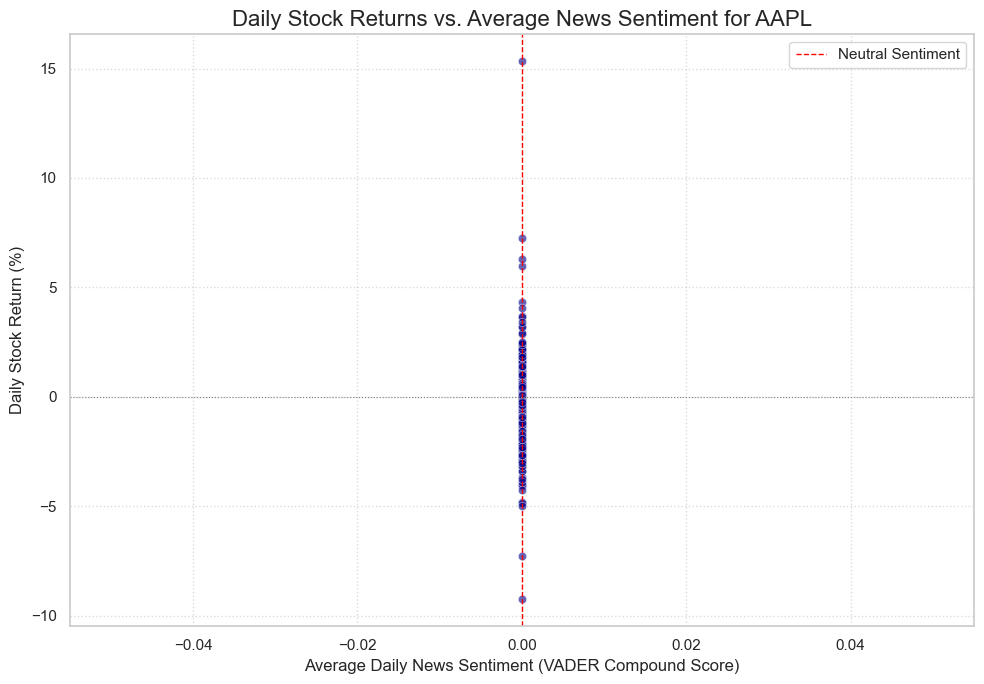

In [17]:
# Code Cell: Calculate and Visualize Correlation

# Ensure both 'Daily_Return' and 'sentiment_score' columns exist before proceeding
if 'Daily_Return' in merged_correlation_df.columns and 'sentiment_score' in merged_correlation_df.columns:
    # Drop rows where either Daily_Return or sentiment_score might be NaN
    # (e.g., the very first Daily_Return after pct_change, or unhandled sentiment NaNs)
    correlation_ready_df = merged_correlation_df.dropna(subset=['Daily_Return', 'sentiment_score'])

    if not correlation_ready_df.empty:
        # Calculate Pearson correlation coefficient
        correlation_coefficient = correlation_ready_df['Daily_Return'].corr(correlation_ready_df['sentiment_score'])
        print(f"\nPearson Correlation between Daily Stock Returns and Average Daily News Sentiment for {stock_symbol}: {correlation_coefficient:.4f}")

        # Visualize the correlation using a scatter plot
        plt.figure(figsize=(10, 7))
        sns.scatterplot(x='sentiment_score', y='Daily_Return', data=correlation_ready_df, alpha=0.6, color='darkblue')
        plt.title(f'Daily Stock Returns vs. Average News Sentiment for {stock_symbol}', fontsize=16)
        plt.xlabel('Average Daily News Sentiment (VADER Compound Score)', fontsize=12)
        plt.ylabel('Daily Stock Return (%)', fontsize=12)
        plt.grid(True, linestyle=':', alpha=0.7)
        plt.axvline(0, color='red', linestyle='--', linewidth=1, label='Neutral Sentiment') # Line at 0 sentiment
        plt.axhline(0, color='gray', linestyle=':', linewidth=0.8) # Line at 0 return
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("No sufficient data for correlation analysis after cleaning. DataFrame is empty.")
else:
    print("Error: 'Daily_Return' or 'sentiment_score' column missing for correlation calculation.")

## 4. Conclusion and Next Steps

This section summarizes the key findings from the correlation analysis and discusses its implications. It also outlines potential limitations of the current analysis and suggests avenues for future research to build upon these insights.

### Key Findings:
* (Interpret your `correlation_coefficient` value here. For example: "A Pearson correlation coefficient of **[YOUR_VALUE]** suggests a **[weak/moderate/strong, positive/negative]** linear relationship between average daily news sentiment and daily stock returns for Apple. This indicates that [explain what this correlation means in practical terms, e.g., 'positive news tends to be associated with slightly higher daily returns, though the relationship is not very strong for direct prediction'].")
* (Discuss any interesting patterns or lack thereof observed from the sentiment score distribution histogram and the correlation scatter plot.)

### Limitations and Future Work:
* **Sentiment Model Nuance:** VADER is a general-purpose sentiment analyzer. A more sophisticated, domain-specific NLP model (e.g., fine-tuned on financial text) might capture nuances specific to financial news more effectively.
* **Temporal Lag:** This analysis primarily focuses on same-day correlation. Investigating lagged effects (e.g., how sentiment on day `t` affects returns on day `t+1` or `t+X`) could reveal different relationships.
* **Data Granularity:** Aggregating sentiment to a daily average might obscure the impact of specific high-impact news events that occur intraday.
* **Causality vs. Correlation:** Correlation does not imply causation. Other market factors and company-specific news could be driving both sentiment and stock price changes.
* **Multi-Stock Analysis:** Extending this analysis to a broader portfolio of stocks or across different industries could reveal variations in how news sentiment impacts different types of companies.

This analysis provides a foundational understanding of the relationship between news sentiment and stock market movements, paving the way for more advanced predictive models.